In [2]:
import jordan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

from tensorflow.keras import Sequential
from keras.layers import RNN


from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.deterministic import Seasonality, DeterministicProcess, TimeTrend
from statsmodels.tsa.vector_ar import var_model


import torch
import torch.nn as nn 
%load_ext autoreload
%autoreload 2

tensor([1.], device='mps:0')


In [48]:
jordan_nn = jordan.JordanRNN(10, 16, 1)

# jordan.train(1000)
model  = Sequential()                           
model.add(keras.layers.SimpleRNN( , activation='relu',input_shape=(15,6)))
model.add(keras.layers.Dense(2 , activation='relu'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss='mse',metrics=['accuracy'])



tensor([1.], device='mps:0')


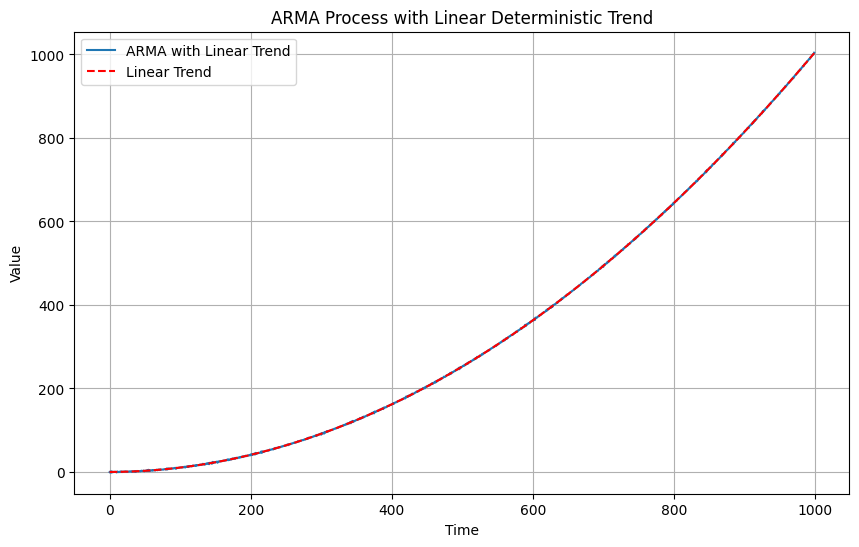

In [49]:
# randomly generate an ARMA(3,4) process
from pandas import date_range


ar = np.array([0.9, 0.5])
ma = np.array([-0.5, 0.2, 0.1])
arma_process = ArmaProcess(ar, ma)

arma_process = arma_process.generate_sample(nsample=1000)

time = np.arange(1000)  # Time index (0 to 999)
b0 = 0  # Intercept
b1 = 0.005  # Slope (rate of change over time)
b2 = 0.001  # Quadratic trend
linear_trend = b0 + b1 * time + b2 * time**2  # Quadratic trend

noise = np.random.normal(0, 10, 1000)  # White noise

seasonal_period = 50  # Length of the seasonal cycle
seasonal_amplitude = 2  # Amplitude of the seasonal component

seasonality = seasonal_amplitude * np.sin(2 * np.pi * time / seasonal_period)

# Add the linear trend to the ARMA data
sample_data_with_trend = arma_process + linear_trend

# Plot the ARMA data with the trend
plt.figure(figsize=(10, 6))
plt.plot(sample_data_with_trend, label="ARMA with Linear Trend")
plt.plot(linear_trend, label="Linear Trend", linestyle='--', color='red')
plt.title("ARMA Process with Linear Deterministic Trend")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

In [53]:
## fit jordan on the data with y being the next value
X = sample_data_with_trend[:-1]
y = sample_data_with_trend[1:]
X = np.expand_dims(X, axis=1)
y = np.expand_dims(y, axis=1)
# make sure X and y are tensors
#make batches of 10
X = np.array_split(X, 100)

# Pad the last batch if necessary
if len(X[-1]) < len(X[0]):
    padding = np.zeros((len(X[0]) - len(X[-1]), X[0].shape[1]))
    X[-1] = np.vstack((X[-1], padding))

#turn into tensor
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

#train the model

jordan_nn.fit(X, y, 100)

tensor([1.], device='mps:0')
Epoch [1/100], Loss: 37010.2969 at time 0.09 seconds
Epoch [10/100], Loss: 6792.0513 at time 0.77 seconds
Epoch [20/100], Loss: 2948.5869 at time 0.86 seconds
Epoch [30/100], Loss: 1611.0605 at time 0.85 seconds
Epoch [40/100], Loss: 1089.4377 at time 0.85 seconds
Epoch [50/100], Loss: 946.0604 at time 0.85 seconds
Epoch [60/100], Loss: 886.1895 at time 0.85 seconds
Epoch [70/100], Loss: 779.5871 at time 0.89 seconds
Epoch [80/100], Loss: 658.4406 at time 0.85 seconds
Epoch [90/100], Loss: 567.2061 at time 0.85 seconds
Epoch [100/100], Loss: 488.2101 at time 0.85 seconds


(tensor([[-9.8810]], device='mps:0', grad_fn=<LinearBackward0>),
 488.2101135253906)

In [64]:
preds = jordan_nn.predict(X[1])

tensor([1.], device='mps:0')
torch.Size([1, 1])
torch.Size([1, 1])


RuntimeError: linear(): input and weight.T shapes cannot be multiplied (1x2 and 11x16)

In [81]:
from tensorflow.keras import layers, models

# Define a custom RNN cell (e.g., Jordan RNN)
class JordanRNNCell(layers.Layer):
    def __init__(self, units, output_size, **kwargs):
        super(JordanRNNCell, self).__init__(**kwargs)
        self.units = units
        self.output_size = output_size

    @property
    def state_size(self):
        return self.output_size

    def build(self, input_shape):
        input_dim = input_shape[-1]
        # Define weights and biases here
        self.W_xh = self.add_weight(shape=(input_dim, self.units), name='W_xh')
        self.W_oh = self.add_weight(shape=(self.output_size, self.units), name='W_oh')
        self.b_h = self.add_weight(shape=(self.units,), name='b_h')
        self.W_hy = self.add_weight(shape=(self.units, self.output_size), name='W_hy')
        self.b_y = self.add_weight(shape=(self.output_size,), name='b_y')

    def call(self, inputs, states):
        prev_output = states[0]
        h = tf.matmul(inputs, self.W_xh) + tf.matmul(prev_output, self.W_oh) + self.b_h
        h = tf.nn.tanh(h)
        y = tf.matmul(h, self.W_hy) + self.b_y
        y = tf.nn.softmax(y)
        return y, [y]

# Wrap the custom cell in an RNN layer
custom_cell = JordanRNNCell(units=128, output_size=10)
rnn_layer = layers.RNN(custom_cell, return_sequences=True, return_state=True)

# Build the model
inputs = layers.Input(shape=(15, 20))  # (time_steps, input_dim)
outputs, final_state = rnn_layer(inputs)
predictions = layers.Dense(10, activation='softmax')(outputs)
model = models.Model(inputs, predictions)
model.compile(optimizer='adam', loss='mse', metrics=['f1'])

In [3]:
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices('GPU')
print("\nGPUs: ", gpus)


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

GPUs:  []
